In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from itertools import combinations
from sklearn.cluster import SpectralClustering

sns.set_theme()

def read_df(path):
    return pd.read_csv(path, sep="\t", compression="gzip", na_values="\\N")

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Movies dataset

In [3]:
# Load datasets
ratings = read_df("data/title.ratings.tsv.gz")
basics = read_df("data/title.basics.tsv.gz")
# Only keep movies
df = pd.merge(ratings, basics, on="tconst")
df_movies = df[df['titleType']=='movie']
# df_movies = df_movies[df_movies['numVotes'] > 10000]
df_movies.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
339,tt0000502,4.5,14,movie,Bohemios,Bohemios,0.0,1905.0,NaN,100.0,NaN
373,tt0000574,6.0,758,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,NaN,70.0,"Action,Adventure,Biography"
382,tt0000591,4.6,17,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,NaN,90.0,Drama
397,tt0000615,4.5,23,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,NaN,NaN,Drama
405,tt0000630,3.8,24,movie,Hamlet,Amleto,0.0,1908.0,NaN,NaN,Drama


In [4]:
movies_df = df_movies[['tconst', 'averageRating', 'numVotes', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres']]
movies_df

,tconst,averageRating,numVotes,primaryTitle,startYear,runtimeMinutes,genres
339,tt0000502,4.5,14,Bohemios,1905.0,100.0,NaN
373,tt0000574,6.0,758,The Story of the Kelly Gang,1906.0,70.0,"Action,Adventure,Biography"
382,tt0000591,4.6,17,The Prodigal Son,1907.0,90.0,Drama
397,tt0000615,4.5,23,Robbery Under Arms,1907.0,NaN,Drama
405,tt0000630,3.8,24,Hamlet,1908.0,NaN,Drama
...,...,...,...,...,...,...,...
1230928,tt9916270,5.8,1327,Il talento del calabrone,2020.0,84,Thriller
1230932,tt9916362,6.4,4523,Coven,2020.0,92,"Drama,History"
1230936,tt9916428,3.6,15,The Secret of China,2019.0,NaN,"Adventure,History,War"
1230940,tt9916538,8.3,6,Kuambil Lagi Hatiku,2019.0,123,Drama


In [5]:
movies_df.to_csv("data/movie_dataset.csv", index=False)

In [6]:
print(f"There are %d movies in the dataset." % len(df_movies))

There are 276810 movies in the dataset.


In [7]:
# Separate the genres into categories
dummies = pd.get_dummies(df_movies['genres'])
genres = [c for c in dummies.columns if ',' not in c]
for col in genres:
    df_movies[col] = dummies[[c for c in dummies.columns if col in c]].sum(axis=1)
df_movies.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
339,tt0000502,4.5,14,movie,Bohemios,Bohemios,0.0,1905.0,NaN,100.0,...,0,0,0,0,0,0,0,0,0,0
373,tt0000574,6.0,758,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,NaN,70.0,...,0,0,0,0,0,0,0,0,0,0
382,tt0000591,4.6,17,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,NaN,90.0,...,0,0,0,0,0,0,0,0,0,0
397,tt0000615,4.5,23,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
405,tt0000630,3.8,24,movie,Hamlet,Amleto,0.0,1908.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print(genres)

['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']


Here we are interested in the average rating and number of votes of the movies and also their genres and year they came out.

In [9]:
df_movies.describe()

,averageRating,numVotes,isAdult,startYear,endYear,Action,Adult,Adventure,Animation,Biography,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
count,276810.000000,2.768100e+05,276810.000000,276779.000000,0.0,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,...,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000
mean,6.145882,3.481787e+03,0.016694,1993.319273,NaN,0.103436,0.015754,0.062801,0.017189,0.030411,...,0.037408,0.002363,0.000166,0.111105,0.023702,0.011918,0.000036,0.081908,0.021426,0.018280
std,1.343272,3.373317e+04,0.128122,25.720192,NaN,0.304527,0.124524,0.242605,0.129974,0.171715,...,0.189761,0.048550,0.012890,0.314263,0.152120,0.108517,0.006010,0.274225,0.144801,0.133961
min,1.000000,5.000000e+00,0.000000,1896.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.300000,1.800000e+01,0.000000,1977.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.300000,5.700000e+01,0.000000,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.100000,2.950000e+02,0.000000,2014.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,2.569002e+06,1.000000,2022.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df_movies["logNumVotes"] = np.log(df_movies["numVotes"])

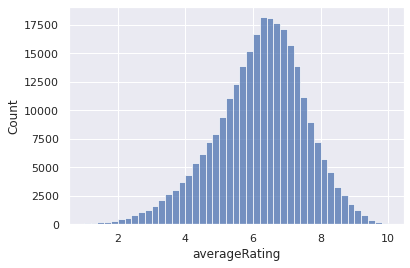

In [11]:
# How are the ratings distributed
sns.histplot(data=df_movies, x="averageRating", binwidth=0.20);

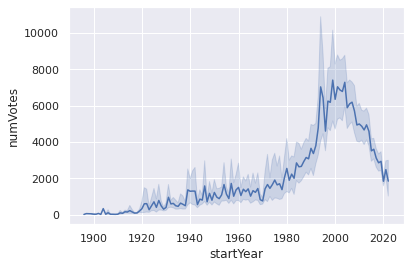

In [12]:
# Do newer movies receive more ratings ? 
sns.lineplot(data=df_movies, x="startYear", y="numVotes");

In [13]:
# What genres of movies receive more attention over time ?
# TODO: only keep n most relevant genres
df_movies["genres"].apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

339             None
373           Action
373        Adventure
373        Biography
382            Drama
             ...    
1230936    Adventure
1230936      History
1230936          War
1230940        Drama
1230949         None
Name: genres, Length: 474772, dtype: object

In [14]:
# What genres of movies receive more attention over time ?
# TODO: only keep n most relevant genres
# sns.barplot(data=df_movies.explode("genres"), x="genres", y="numVotes");

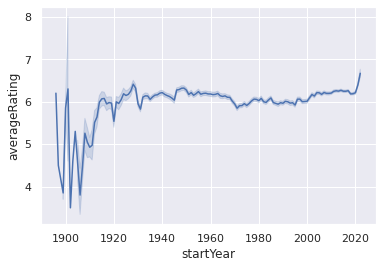

In [15]:
sns.lineplot(data=df_movies, x="startYear", y="averageRating");
# Important question: the increase of the average rating is due to real
# improvement of the movies or are we biased to give a better rating to
# what is more recent 

### Actors dataset

Here we are mostly interested in the actors, and eventually directors. The attribute "knownForTitle" will be used to link the actors together.

In [16]:
actors = pd.read_csv("data/name.basics.tsv.gz", sep="\t", compression="gzip", na_values = "\\N")
actors.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0050419,tt0072308,tt0053137"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0037382,tt0071877,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0057345,tt0056404,tt0049189,tt0054452"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0069467,tt0060827,tt0083922,tt0050986"


In [17]:
actors = actors.dropna()[
    actors["primaryProfession"].dropna().str.contains("actor")
    | actors["primaryProfession"].dropna().str.contains("actress")
]
actors.head()


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0050419,tt0072308,tt0053137"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0037382,tt0071877,tt0117057,tt0038355"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0069467,tt0060827,tt0083922,tt0050986"
5,nm0000006,Ingrid Bergman,1915.0,1982.0,"actress,soundtrack,producer","tt0034583,tt0036855,tt0038109,tt0077711"


In [18]:
actors_df = actors[['nconst', 'primaryName', 'knownForTitles']]
actors_df

,nconst,primaryName,knownForTitles
0,nm0000001,Fred Astaire,"tt0031983,tt0050419,tt0072308,tt0053137"
1,nm0000002,Lauren Bacall,"tt0037382,tt0071877,tt0117057,tt0038355"
3,nm0000004,John Belushi,"tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,"tt0069467,tt0060827,tt0083922,tt0050986"
5,nm0000006,Ingrid Bergman,"tt0034583,tt0036855,tt0038109,tt0077711"
...,...,...,...
11510809,nm9961584,Semra Atilay,"tt0263409,tt0367627,tt0368809,tt0401531"
11515523,nm9967094,Allyn M. Schmitz,"tt5591666,tt2247057"
11518604,nm9970751,Helmut Winschermann,"tt0063136,tt8696414"
11518655,nm9970811,Cristian Mosquera,"tt2066179,tt8696516"


In [19]:
actors_df.dropna(inplace=True)
actors["knownForTitles"] = actors_df["knownForTitles"].str.split(",")
df_movies_tconst = df_movies.set_index("tconst")


def numvotes(grp):
    try:
        return df_movies_tconst.loc[grp.array]["numVotes"].sum()
    except KeyError:
        return


actor_numvotes = (
    actors.explode("knownForTitles")
    .groupby("nconst")["knownForTitles"]
    .apply(numvotes)
    .dropna()
    .rename("numVotes")
)
actors_merge = actors.merge(actor_numvotes, on="nconst")
# df_movies_tconst.loc[splitted_tconsts.explode().loc[0].array]["numVotes"].sum()


In [20]:
actors = actors_merge.sort_values("numVotes", ascending=False)
actors

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,numVotes
14161,nm0504226,Andrew Lesnie,1956.0,2015.0,"cinematographer,camera_department,actor","[tt0167261, tt0360717, tt0167260, tt0120737]",5568009.0
19894,nm0721615,Don Reynolds,1937.0,2019.0,"actor,miscellaneous","[tt0120737, tt0167260, tt0035423, tt0167261]",5236632.0
85,nm0000453,Ian Holm,1931.0,2020.0,"actor,soundtrack,animation_department","[tt0120737, tt0120681, tt0382932, tt0167260]",4405417.0
18037,nm0652906,Johnny Otis,1921.0,2012.0,"soundtrack,actor","[tt0111161, tt0088763, tt0790636, tt0117381]",4404535.0
219,nm0001190,David Prowse,1935.0,2020.0,"actor,miscellaneous","[tt0066921, tt0076759, tt0080684, tt0086190]",4379166.0
...,...,...,...,...,...,...,...
27769,nm12830216,Nestor Pogaçe,1915.0,1983.0,actor,[tt0354240],6.0
31453,nm7694782,Damjan Berkopec,1972.0,2010.0,"actor,editor",[tt5159852],5.0
29612,nm2291091,Constance Navratil,1930.0,2014.0,actress,[tt0810786],5.0
28205,nm1421246,Beppie Nooy Sr.,1893.0,1976.0,actress,[tt0219548],5.0


In [21]:
actors_top = actors.sort_values("numVotes", ascending=False).head(100)
actors_top.to_csv("data/actors_top.csv", index=False)
actors_top.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,numVotes
14161,nm0504226,Andrew Lesnie,1956.0,2015.0,"cinematographer,camera_department,actor","[tt0167261, tt0360717, tt0167260, tt0120737]",5568009.0
19894,nm0721615,Don Reynolds,1937.0,2019.0,"actor,miscellaneous","[tt0120737, tt0167260, tt0035423, tt0167261]",5236632.0
85,nm0000453,Ian Holm,1931.0,2020.0,"actor,soundtrack,animation_department","[tt0120737, tt0120681, tt0382932, tt0167260]",4405417.0
18037,nm0652906,Johnny Otis,1921.0,2012.0,"soundtrack,actor","[tt0111161, tt0088763, tt0790636, tt0117381]",4404535.0
219,nm0001190,David Prowse,1935.0,2020.0,"actor,miscellaneous","[tt0066921, tt0076759, tt0080684, tt0086190]",4379166.0


In [22]:
# Get edge list
import itertools

actors_top["knownForTitles"] = actors_top["knownForTitles"].apply(set)
actors_top = actors_top.reset_index()
actors_top = actors_top.set_index("nconst")
actop1 = pd.DataFrame(
    data=list(combinations(actors_top.index.tolist(), 2)), columns=["src", "dst"]
)
actop1

,src,dst
0,nm0504226,nm0721615
1,nm0504226,nm0000453
2,nm0504226,nm0652906
3,nm0504226,nm0001190
4,nm0504226,nm0508742
...,...,...
4945,nm0532954,nm0437939
4946,nm0532954,nm0460810
4947,nm0922187,nm0437939
4948,nm0922187,nm0460810


In [23]:
actop2 = actop1.apply(
    lambda row: len(
        actors_top.loc[row["src"]]["knownForTitles"].intersection(
            actors_top.loc[row["dst"]]["knownForTitles"]
        )
    ),
    axis=1,
)

actop2 = actop2[actop2 >= 1].rename("weights")
edge_list = actop1.join(actop2).dropna()
edge_list.to_csv("data/edge_list.csv", index=False)
edge_list


,src,dst,weights
0,nm0504226,nm0721615,3.0
1,nm0504226,nm0000453,2.0
5,nm0504226,nm0026428,1.0
11,nm0504226,nm0000489,2.0
14,nm0504226,nm0397102,2.0
...,...,...,...
4893,nm0003738,nm0437939,1.0
4895,nm0001924,nm0681920,1.0
4903,nm0001924,nm0437939,1.0
4912,nm0681920,nm0437939,1.0


In [24]:
# exploded_titles = actors.knownForTitles.apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

In [25]:
# actors = actors.join(exploded_titles, rsuffix="_ex")

In [26]:
# G_actors = nx.Graph()
# G_actors.add_nodes_from(actors["primaryName"])

In [27]:
# actors.groupby("knownForTitles_ex").primaryName.apply(lambda group: G_actors.add_edges_from(combinations(group, 2)));

In [28]:
# print(nx.info(G_actors))
# nx.draw_spectral(G_actors)
# adj_mat = nx.to_numpy_matrix(G_actors)

# spectral_clustering = SpectralClustering(10, affinity="precomputed").fit(adj_mat)